前面的A和B，分别是对于学习数据做了一些熟悉。
下面，我们看我们基于的学习代码：

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

def input(dataset):
    return dataset.images, dataset.labels.astype(np.int32)

# Specify feature
feature_columns = [tf.feature_column.numeric_column("x", shape=[28, 28])]

# Build 2 layer DNN classifier
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[256, 32],
    optimizer=tf.train.AdamOptimizer(1e-4),
    n_classes=10,
    dropout=0.1,
    model_dir="./tmp/mnist_model"
)

# Define the training inputs
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(mnist.train)[0]},
    y=input(mnist.train)[1],
    num_epochs=None,
    batch_size=50,
    shuffle=True
)

classifier.train(input_fn=train_input_fn, steps=2000)

# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(mnist.test)[0]},
    y=input(mnist.test)[1],
    num_epochs=1,
    shuffle=False
)

# Evaluate accuracy
accuracy_score = classifier.evaluate(input_fn=test_input_fn)["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './tmp/mnist_model', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./tmp/mnist_model/model.ckpt-1
INFO:tensorflow:Saving checkpoints for 2 into ./tmp/mnist_model/model.ckpt.
INFO:tensorflow:loss = 117.992, step = 2
INFO:tensorflow:global_step/sec: 191.025
INFO:tensorflow:loss = 81.7786, step = 102 (0.525 sec)
INFO:tensorflow:global_step/sec: 199.654
INFO:tensorflow:loss = 48.4067, step = 202 (0.502 sec)
INFO:tensorflow:global_step/sec: 207.35

代码来自于这里：

https://codeburst.io/use-tensorflow-dnnclassifier-estimator-to-classify-mnist-dataset-a7222bf9f940
Use Tensorflow DNNClassifier estimator to classify MNIST dataset
（https://gist.githubusercontent.com/marcolanaro/67b77346730c0862b17c4800ee599286/raw/bb2dc2e8b4c962c78cf99b0b61e0d5adc6a53b64/mnist_estimator.py）


它使用MNIST做为入口数据，使用2层DNN classifier来学习。它学习了10万步，精度不错。这里为了节省时间，仅学习了2000步。测试的精度可以达到：93.339998%

从gnt-B.ipynb我们知道，入口数据就是3个对象：train, test, 及validation。然后它们分别有两个属性：images和labels。它们分别是numpy数组。

我们将对gnt做同样的处理。

对于学习的模型，原来的分类器是分了10类：

 n_classes=10,
 
 我们需要分的就多了。有多少个需要识别的汉字，就需要分为多少类。
 以test中的3755为目标吧。
 即： n_classes=3755,

下面尝试做gnt的入口数据处理：

注意：要将RGB图变为灰度图：
http://scikit-image.org/docs/dev/user_guide/transforming_image_data.html



../data/sandbox/03755
shape of images is:  (120, 64, 64)
sandbox:  120 531 ../data/sandbox/00531/148941.png [[[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]] [[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]
image_data:  [[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1

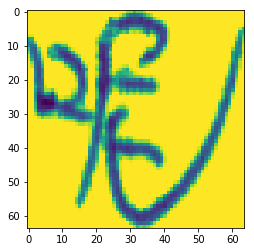

In [6]:
import os
import random
from PIL import *
from numpy import array

IMAGE_SIZE = 64
CHARSET_SIZE = 3755

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize

class DataIterator:
    def __init__(self, data_dir):
        # Set FLAGS.charset_size to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print(truncate_path)
        self.image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                self.image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(self.image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in self.image_names]
        self.images_rgb = [imread(file_name) for file_name in self.image_names]
        self.image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in self.images_rgb]
        self.images = [rgb2gray(item) for item in self.image_resized]
        self.images = array(self.images)
        print ('shape of images is: ', self.images.shape)

    @property
    def size(self):
        return len(self.labels)
    
test_feeder = DataIterator(data_dir='../data/sandbox/')
print ('sandbox: ', test_feeder.size, test_feeder.labels[0], test_feeder.image_names[0], test_feeder.images_rgb[0], test_feeder.images[0])


# show image
import matplotlib.pyplot as plt
first_array=test_feeder.images[0]
image_data = first_array.reshape((IMAGE_SIZE, IMAGE_SIZE))
print ('image_data: ', image_data)


#Not sure you even have to do that if you just want to visualize it
#first_array=255*first_array
#first_array=first_array.astype("uint8")
plt.imshow(image_data)
#Actually displaying the plot if you are not in interactive mode
plt.show()

上面直接读出的，是3个数字（RGB？）一点的数组；如何得到如mnist，一个数一个点的数组？

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/mnist/input_data.py

from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

train的00531目录下，确实是“呢”字。00054目录下，是“也”字。

下面开始训练。由于train数据没有test多，即train只有部份字，而test有3755所有字。所以测试的精度肯定很低。不过，能跑起来，就可以了：

注意，要删除杂质文件，如：.DS_Store

ValueError: invalid literal for int() with base 10: '._.DS_Store'

huoyongxue@HSHY-151-SERVER:~/todo/gnt/data/train$ find . -name '.DS_Store' -type f -delete

huoyongxue@HSHY-151-SERVER:~/todo/gnt/data$ rm train/._.DS_Store


下面将仅训练及测试前37个字。

In [8]:
import tensorflow as tf
import numpy as np
import os
import random
from numpy import array

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize

IMAGE_SIZE = 64
# CHARSET_SIZE = 3755
CHARSET_SIZE = 37

def input(dataset):
    return dataset.images, dataset.labels

class DataSetLoader:
    def __init__(self, data_dir):
        # Set FLAGS.charset_size to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print('Now processing path: ', truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        self.images = [rgb2gray(item) for item in image_resized]
        
        # convert list to numpy array
        self.images = array(self.images)
        self.labels = array(self.labels)

    
train_data = DataSetLoader(data_dir='../data/train_/')
test_data = DataSetLoader(data_dir='../data/test_/')
print ('Data loaded ...')



# Specify feature
feature_columns = [tf.feature_column.numeric_column("x", shape=[IMAGE_SIZE, IMAGE_SIZE])]

# Build 2 layer DNN classifier
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[256, 32],
    optimizer=tf.train.AdamOptimizer(1e-4),
    n_classes=CHARSET_SIZE,
    dropout=0.1,
    model_dir="../dfs/checkpoint/dnn2_model"
)

# Define the training inputs
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(train_data)[0]},
    y=input(train_data)[1],
    num_epochs=None,
    batch_size=50,
    shuffle=True
)
print ('Begin to train ...')

classifier.train(input_fn=train_input_fn, steps=20000)
print ('Train done ...')

# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    y=input(test_data)[1],
    num_epochs=1,
    shuffle=False
)

# Evaluate accuracy
accuracy_score = classifier.evaluate(input_fn=test_input_fn)["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))

../data/train_/00037
../data/test_/00037
Data loaded ...
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../dfs/checkpoint/dnn2_model', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
Begin to train ...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn2_model/model.ckpt-22000
INFO:tensorflow:Saving checkpoints for 22001 into ../dfs/checkpoint/dnn2_model/model.ckpt.
INFO:tensorflow:loss = 36.8806, step = 22001
INFO:tensorflow:global_step/sec: 65.5926
INFO:tensorflow:loss = 22.2147, step = 22101 (1.522 sec)
INFO:tensorflow:global_step/sec: 68.3748
INFO:tensorflow:loss = 32.6996, step = 22201 (1.463 sec)
INFO:tensorflow:global_step/sec: 68.4868
INFO:tensorflow:loss = 46.3469, step = 22301 (1.460 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 71.1411
INFO:tensorflow:loss = 32.1239, step = 29801 (1.407 sec)
INFO:tensorflow:global_step/sec: 69.8178
INFO:tensorflow:loss = 18.5574, step = 29901 (1.431 sec)
INFO:tensorflow:global_step/sec: 71.1452
INFO:tensorflow:loss = 17.6657, step = 30001 (1.407 sec)
INFO:tensorflow:global_step/sec: 70.7656
INFO:tensorflow:loss = 16.9358, step = 30101 (1.413 sec)
INFO:tensorflow:global_step/sec: 72.452
INFO:tensorflow:loss = 14.8062, step = 30201 (1.380 sec)
INFO:tensorflow:global_step/sec: 72.602
INFO:tensorflow:loss = 27.831, step = 30301 (1.377 sec)
INFO:tensorflow:global_step/sec: 72.009
INFO:tensorflow:loss = 27.3041, step = 30401 (1.388 sec)
INFO:tensorflow:global_step/sec: 70.3577
INFO:tensorflow:loss = 31.3117, step = 30501 (1.423 sec)
INFO:tensorflow:global_step/sec: 71.351
INFO:tensorflow:loss = 14.7503, step = 30601 (1.400 sec)
INFO:tensorflow:global_step/sec: 72.4278
INFO:tensorflow:loss = 22.7981, step = 30701 (1.381 sec)
INFO:tensorflow:global_st

INFO:tensorflow:global_step/sec: 68.9259
INFO:tensorflow:loss = 22.5674, step = 38201 (1.452 sec)
INFO:tensorflow:global_step/sec: 69.2563
INFO:tensorflow:loss = 18.7244, step = 38301 (1.444 sec)
INFO:tensorflow:global_step/sec: 69.1149
INFO:tensorflow:loss = 13.5106, step = 38401 (1.447 sec)
INFO:tensorflow:global_step/sec: 67.3359
INFO:tensorflow:loss = 10.3801, step = 38501 (1.485 sec)
INFO:tensorflow:global_step/sec: 66.1444
INFO:tensorflow:loss = 13.6965, step = 38601 (1.513 sec)
INFO:tensorflow:global_step/sec: 67.9029
INFO:tensorflow:loss = 11.3877, step = 38701 (1.472 sec)
INFO:tensorflow:global_step/sec: 68.3495
INFO:tensorflow:loss = 19.6706, step = 38801 (1.462 sec)
INFO:tensorflow:global_step/sec: 67.687
INFO:tensorflow:loss = 20.5509, step = 38901 (1.477 sec)
INFO:tensorflow:global_step/sec: 66.8361
INFO:tensorflow:loss = 17.8339, step = 39001 (1.497 sec)
INFO:tensorflow:global_step/sec: 68.3487
INFO:tensorflow:loss = 17.2506, step = 39101 (1.462 sec)
INFO:tensorflow:globa

下面使用5层DNN进行训练：


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
from numpy import array

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize

IMAGE_SIZE = 64
# CHARSET_SIZE = 3755
CHARSET_SIZE = 37

def input(dataset):
    return dataset.images, dataset.labels

class DataSetLoader:
    def __init__(self, data_dir):
        # Set CHARSET_SIZE to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print('Now processing path: ', truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        self.images = [rgb2gray(item) for item in image_resized]
        
        # convert list to numpy array
        self.images = array(self.images)
        self.labels = array(self.labels)
    
train_data = DataSetLoader(data_dir='../data/train_/')
print ('Train data loaded.')

# Specify feature
feature_columns = [tf.feature_column.numeric_column("x", shape=[IMAGE_SIZE, IMAGE_SIZE])]

# Build 2 layer DNN classifier
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    hidden_units=[4096, 256, 256, 256, 64],
    optimizer=tf.train.AdamOptimizer(1e-4),
    n_classes=CHARSET_SIZE,
    dropout=0.1,
    model_dir="../dfs/checkpoint/dnn5_model"
)

# Define the training inputs
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(train_data)[0]},
    y=input(train_data)[1],
    num_epochs=None,
    batch_size=50,
    shuffle=True
)

classifier.train(input_fn=train_input_fn, steps=200000)

test_data = DataSetLoader(data_dir='../data/test_/')
print ('Train done, begin to test ...')
# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    y=input(test_data)[1],
    num_epochs=1,
    shuffle=False
)

# Evaluate accuracy
accuracy_score = classifier.evaluate(input_fn=test_input_fn)["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))

Now processing path:  ../data/train_/00037
Train data loaded.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../dfs/checkpoint/dnn5_model', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn5_model/model.ckpt-20001
INFO:tensorflow:Saving checkpoints for 20002 into ../dfs/checkpoint/dnn5_model/model.ckpt.
INFO:tensorflow:loss = 30.754, step = 20002
INFO:tensorflow:global_step/sec: 4.72568
INFO:tensorflow:loss = 33.6694, step = 20102 (21.166 sec)
INFO:tensorflow:global_step/sec: 5.37136
INFO:tensorflow:loss = 25.8949, step = 20202 (18.614 sec)
INFO:tensorflow:global_step/sec: 6.24306
INFO:tensorflow:loss = 18.7259, step = 20302 (16.018 sec)
INFO:tensorflow:global

使用上次的model，继续train：参考https://colab.research.google.com/drive/1eSVbFPcHHt1BbSKwzdclRDeLIIx_5ZOR
linear-regression-D.ipynb


In [5]:
# from: https://www.kaggle.com/jeffcarp/example-save-and-load-a-tensorflow-model

import tensorflow as tf
import numpy as np
import os
import random
from numpy import array

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize

from tensorflow.contrib.learn.python.learn.estimators import run_config
from tensorflow.contrib.training.python.training import hparam

IMAGE_SIZE = 64
# CHARSET_SIZE = 3755
CHARSET_SIZE = 37

def input(dataset):
    return dataset.images, dataset.labels

# Define the training inputs
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(train_data)[0]},
    y=input(train_data)[1],
    num_epochs=None,
    batch_size=50,
    shuffle=True
)

class DataSetLoader:
    def __init__(self, data_dir):
        # Set CHARSET_SIZE to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print('Now processing path: ', truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        self.images = [rgb2gray(item) for item in image_resized]
        
        # convert list to numpy array
        self.images = array(self.images)
        self.labels = array(self.labels)
    
train_data = DataSetLoader(data_dir='../data/train_/')

# Specify feature
feature_columns = [tf.feature_column.numeric_column("x", shape=[IMAGE_SIZE, IMAGE_SIZE])]

def make_estimator(model_dir):
    config = run_config.RunConfig(model_dir=model_dir)

    return tf.estimator.DNNClassifier (
        config=config,
        feature_columns=feature_columns,
        hidden_units=[4096, 256, 256, 256, 64],
        optimizer=tf.train.AdamOptimizer(1e-4),
        n_classes=CHARSET_SIZE,
        dropout=0.1
    )

MODEL_DIR = "../dfs/checkpoint/dnn5_model"
model_from_checkpoint = make_estimator(MODEL_DIR)

model_from_checkpoint.train(input_fn=train_input_fn, steps=200)
print ('Train done, begin to test ...')
test_data = DataSetLoader(data_dir='../data/test_/')
# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    y=input(test_data)[1],
    num_epochs=1,
    shuffle=False
)

# Evaluate accuracy
accuracy_score = model_from_checkpoint.evaluate(input_fn=test_input_fn)["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))

Now processing path:  ../data/train_/00037
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa766334f98>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../dfs/checkpoint/dnn5_model'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn5_model/model.ckpt-23201
INFO:tensorflow:Saving checkpoints for 23202 into ../dfs/checkpoint/dnn5_model/model.ckpt.
INFO:tensorflow:loss = 7.43387, step = 23202
INFO:tensorflow:global_step/sec: 7.6

上面还真好使：
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn5_model/model.ckpt-20000
INFO:tensorflow:Saving checkpoints for 20001 into ../dfs/checkpoint/dnn5_model/model.ckpt.
INFO:tensorflow:loss = 5.79399, step = 20001

从上次的20000步开始。从这里看来，即前使用浏览器训练时没有了响应，后台也是保存了的。就是前台失去了联系。
下面我们做点有趣的：手工观察测试情况。参考https://colab.research.google.com/drive/1eSVbFPcHHt1BbSKwzdclRDeLIIx_5ZOR#scrollTo=JkbP89CJd1bC （linear-regression-D.ipynb）

In [1]:
# from: https://www.kaggle.com/jeffcarp/example-save-and-load-a-tensorflow-model

import tensorflow as tf
import numpy as np
import os
import random
from numpy import array

from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.transform import resize

from tensorflow.contrib.learn.python.learn.estimators import run_config
from tensorflow.contrib.training.python.training import hparam

IMAGE_SIZE = 64
# CHARSET_SIZE = 3755
CHARSET_SIZE = 37

def input(dataset):
    return dataset.images, dataset.labels

class DataSetLoader:
    def __init__(self, data_dir):
        # Set CHARSET_SIZE to a small value if available computation power is limited.
        truncate_path = data_dir + ('%05d' % CHARSET_SIZE)
        print('Now processing path: ', truncate_path)
        image_names = []
        for root, sub_folder, file_list in os.walk(data_dir):
            if root < truncate_path:
                image_names += [os.path.join(root, file_path) for file_path in file_list]
        random.shuffle(image_names)
        self.labels = [int(file_name[len(data_dir):].split(os.sep)[0]) for file_name in image_names]
        images_rgb = [imread(file_name) for file_name in image_names]
        image_resized = [resize(image, (IMAGE_SIZE, IMAGE_SIZE)) for image in images_rgb]
        self.images = [rgb2gray(item) for item in image_resized]
        
        # convert list to numpy array
        self.images = array(self.images)
        self.labels = array(self.labels)

# Specify feature
feature_columns = [tf.feature_column.numeric_column("x", shape=[IMAGE_SIZE, IMAGE_SIZE])]

def make_estimator(model_dir):
    config = run_config.RunConfig(model_dir=model_dir)

    return tf.estimator.DNNClassifier (
        config=config,
        feature_columns=feature_columns,
        hidden_units=[4096, 256, 256, 256, 64],
        optimizer=tf.train.AdamOptimizer(1e-4),
        n_classes=CHARSET_SIZE,
        dropout=0.1
    )

MODEL_DIR = "../dfs/checkpoint/dnn5_model"
model_from_checkpoint = make_estimator(MODEL_DIR)

test_data = DataSetLoader(data_dir='../data/test_/')
# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    y=input(test_data)[1],
    num_epochs=1,
    shuffle=False
)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": input(test_data)[0]},
    num_epochs=1,
    shuffle=False)

# Evaluate accuracy
accuracy_score = model_from_checkpoint.evaluate(input_fn=test_input_fn)["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))

# manually test
predictions = list(model_from_checkpoint.predict(input_fn=predict_input_fn))
predictions_value_array = list(predictions)

import matplotlib.pyplot as plt

def test_n_hanzi(predictions_values, index):
    # Show the image of the input data
    image_data_array = test_data.images[index]
    image_data = image_data_array.reshape((IMAGE_SIZE, IMAGE_SIZE))
    plt.imshow(image_data)
    plt.show()
    
    # show the prediction result
    print ('Prediction label is: ', np.argmax(predictions_values[index]["probabilities"]))
    
    # Show the lable
    print ("Real label is: %d"%(test_data.labels[index]))

for i in range(37):
    test_n_hanzi(predictions_value_array, i)    

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7febdc9167b8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../dfs/checkpoint/dnn5_model'}
Now processing path:  ../data/test_/00037
INFO:tensorflow:Starting evaluation at 2018-04-21-02:14:28
INFO:tensorflow:Restoring parameters from ../dfs/checkpoint/dnn5_model/model.ckpt-220001
INFO:tensorflow:Finished evaluation at 2018-04-21-02:14:30
INFO:tensorflow:Saving dict for global step 220001: accuracy = 0.823077, average_loss = 1.31783, g

Prediction label is:  26
Real label is: 16


Prediction label is:  35
Real label is: 35


Prediction label is:  21
Real label is: 21


Prediction label is:  35
Real label is: 35


Prediction label is:  26
Real label is: 26


Prediction label is:  31
Real label is: 31


Prediction label is:  11
Real label is: 11


Prediction label is:  25
Real label is: 25


Prediction label is:  28
Real label is: 28


Prediction label is:  10
Real label is: 10


Prediction label is:  21
Real label is: 21


Prediction label is:  9
Real label is: 9


Prediction label is:  25
Real label is: 25


Prediction label is:  21
Real label is: 21


Prediction label is:  6
Real label is: 6


Prediction label is:  20
Real label is: 20


Prediction label is:  1
Real label is: 1


Prediction label is:  36
Real label is: 36


Prediction label is:  9
Real label is: 9


Prediction label is:  1
Real label is: 1


Prediction label is:  27
Real label is: 27


Prediction label is:  17
Real label is: 19


Prediction label is:  28
Real label is: 27


Prediction label is:  1
Real label is: 1


Prediction label is:  35
Real label is: 35


Prediction label is:  33
Real label is: 33


Prediction label is:  13
Real label is: 16


Prediction label is:  28
Real label is: 28


Prediction label is:  15
Real label is: 15


Prediction label is:  34
Real label is: 34


Prediction label is:  13
Real label is: 13


Prediction label is:  2
Real label is: 2


Prediction label is:  29
Real label is: 29


Prediction label is:  32
Real label is: 32


Prediction label is:  14
Real label is: 14


Prediction label is:  32
Real label is: 32


Prediction label is:  29
Real label is: 29
